In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')


The dataset we are going to use contains data about songs released in the span of around 100 years. Along with some general information about songs some scientific measures of sound are also provided like loudness, acoustics, speechiness, and so on.

In [88]:
tracks = pd.read_csv('data/tracks.csv')
tracks.head()

,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


Data Cleaning

Data Cleaning is one of the important steps without which data will be of no use because the raw data contains a lot of noises that must be removed else the observations made from it will be inaccurate and if we are building a model upon it then it’s performance will be poor as well. Steps included in the data cleaning are outlier removal, null value imputation, and fixing the skewness of the data.

In [89]:
tracks.shape

(114000, 20)

Now. let’s check if there are null values in the columns of our data frame.

In [90]:
tracks.isnull().sum()

track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

we will remove rows with null values.

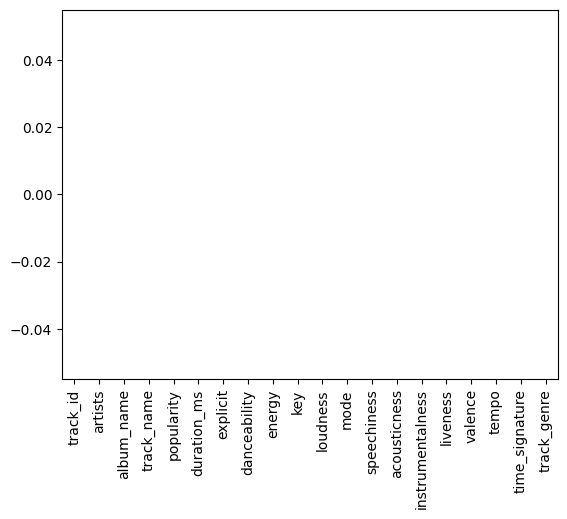

In [91]:
tracks.dropna(inplace=True)
tracks.isnull().sum().plot.bar()
plt.show()

Now let’s remove some columns which we won’t be using to build our recommender system.

In [92]:
tracks = tracks.drop(['track_id','time_signature'], axis = 1)
tracks.head()

,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,track_genre
0,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,acoustic
1,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,acoustic
2,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,acoustic
3,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,acoustic
4,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,acoustic


# Exploratory Data Analysis

EDA is an approach to analyzing the data using visual techniques. It is used to discover trends, and patterns, or to check assumptions with the help of statistical summaries and graphical representations. 

The dataset we have contains around 14 numerical columns but we cannot visualize such high-dimensional data. But to solve this problem t-SNE comes to the rescue. t-SNE is an algorithm that can convert high dimensional data to low dimensions and uses some non-linear method to do so which is not a concern of this article.

In [93]:
float_columns = tracks.select_dtypes(include=['float']).columns
tracks_float_only = tracks[float_columns].copy()

We do the above because if u see below in 2nd line of code we can convert only numeric values ie  only numeric columns are passed to the fit_transform method of TSNE. For that the data frame must have only float values.

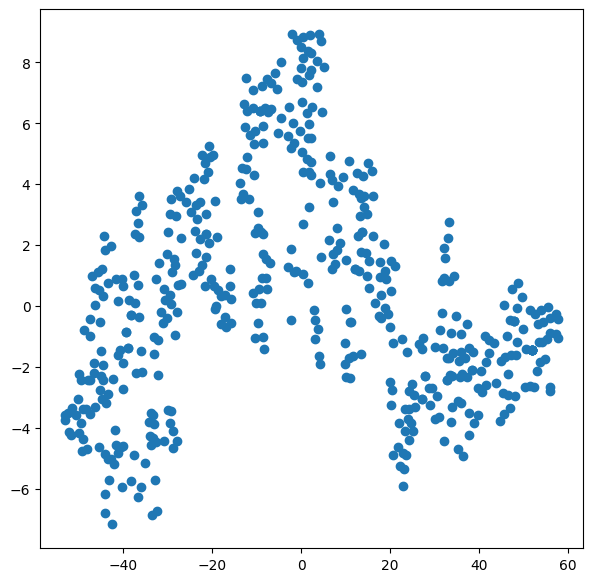

In [94]:
model = TSNE(n_components = 2, random_state = 0)
tsne_data = model.fit_transform(tracks_float_only.head(500))
plt.figure(figsize = (7, 7))
plt.scatter(tsne_data[:,0], tsne_data[:,1])
plt.show()

As we know multiple versions of the same song are released hence we need to remove the different versions of the same sone as we are building a content-based recommender system behind which the main worker is the cosine similarity function our system will recommend the versions of the same song if available and that is not what we want.

In [95]:
tracks['track_name'].nunique(), tracks.shape

(73608, (113999, 18))

So, our concern was right so, let’s remove the duplicate rows based upon the song names.

In [96]:
tracks = tracks.sort_values(by='popularity', ascending=False)
tracks.drop_duplicates(subset=['track_name'], keep='first', inplace=True)

In [97]:
floats = []
for col in tracks.columns:
    if tracks[col].dtypes == 'float':
        floats.append(col)
len(floats)

9

There is a total of 10 such columns with float values in them. Let’s draw their distribution plot to get insights into the distribution of the data.

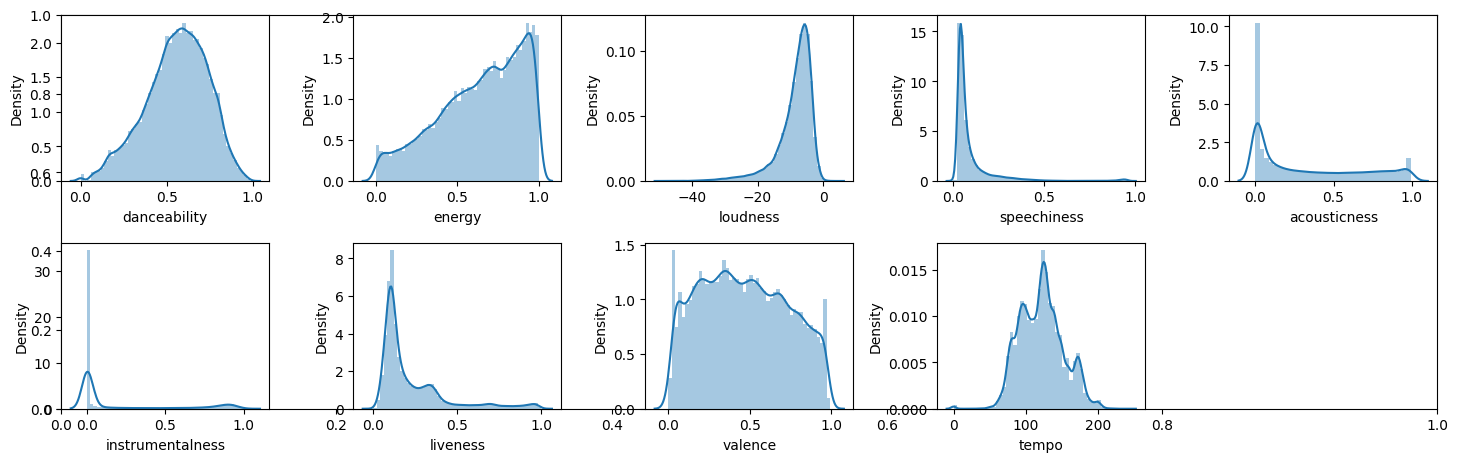

In [98]:
plt.subplots(figsize=(15,5))
for i,col in enumerate(floats):
    plt.subplot(2,5,i+1)
    sb.distplot(tracks[col])
plt.tight_layout()
plt.show()

BELOW

In Jupyter Notebook, %%capture hides output and stores it. Here, CountVectorizer from scikit-learn is used to process genre data (tracks['genres']). It learns genre vocabulary with fit(), preparing data for machine learning by transforming genres into a numerical matrix.

In [99]:
%%capture
song_vectorizer = CountVectorizer()
song_vectorizer.fit(tracks['track_genre'])

As the dataset is too large computation cost/time will to too high so, we will show the implementation of the recommended system by using the most popular 10,000 songs.

In [100]:
tracks = tracks.sort_values(by='popularity', ascending=False).head(10000)

Below is a helper function to get similarities for the input song with each song in the dataset.

In [101]:
def get_similarities(song_name, data):
    # Getting vector for the input song.
    text_array1 = song_vectorizer.transform(data[data['track_name']==song_name]['track_genre']).toarray()
    num_array1 = data[data['track_name']==song_name].select_dtypes(include=np.number).to_numpy()

    # We will store similarity for each row of the dataset
    sim=[]
    for idx, row in data.iterrows():
        name = row['track_name']

        # Getting vector for current song.
        test_array2 = song_vectorizer.transform(data[data['track_name']==name]['track_genre']).toarray()
        num_array2 = data[data['track_name']==name].select_dtypes(include=np.number).to_numpy()

        # Calculating similarities for text as well as numeric features
        text_sim = cosine_similarity(text_array1, test_array2)[0][0]
        num_sim = cosine_similarity(num_array1, num_array2)[0][0]
        sim.append(text_sim + num_sim)
        
    return sim



To calculate the similarity between the two vectors we have used the concept of cosine similarity.

In [102]:
def recommend_songs(song_name, data=tracks):
    # Base case
    if tracks[tracks['track_name']==song_name].shape[0] == 0:
        print('This song is either not so popular or you\
    have entered invalid_name.\n Some songs you may like:\n')
        
        for song in data.sample(n=5)['track_name'].values:
            print(song)
        return
    
    # Getting similar songs
    data['similarity_factor'] = get_similarities(song_name, data)

    data.sort_values(by=['similarity_factor', 'popularity'], ascending=[False, False], inplace=True)

    # First song will be the input song itself as the similarity will be highest.
    display(data[['track_name','artists']][2:7])

Now, it’s time to see the recommender system at work. Let’s see which songs are recommender system will recommend if he/she listens to the famous song ‘Shape of you’.

In [119]:
recommend_songs('Love Me Like You Do - From "Fifty Shades Of Grey"')

,track_name,artists
31550,talk is overrated,Jeremy Zucker;blackbear
31885,Don’t Let Me Let Go (with ILLENIUM & EVAN GIIA),Dillon Francis;ILLENIUM;EVAN GIIA
31687,None Of My Business,Cher Lloyd
31779,The Way You Felt,Alec Benjamin
31823,avalanche,Christian French
